<a href="https://colab.research.google.com/github/Waiyanheinoo/leastsquare/blob/main/linear_algebra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# SOLVING OVERDETERMINED SYSTEMS USING LEAST SQUARE
# CSC262 Linear Algebra Mini Project

# CELL 1: Setup and Imports
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True

# Create directory for saving plots
os.makedirs('plots', exist_ok=True)

print("✓ Setup complete! Ready to run experiments.\n")


✓ Setup complete! Ready to run experiments.



In [ ]:
# CELL 2: Core Least Squares Implementations
# ============================================================================

def solve_normal_equations(A: np.ndarray, b: np.ndarray) -> Tuple[np.ndarray, Dict]:
    """
    Solve least squares using Normal Equations: x = (A^T A)^(-1) A^T b
    """
    start_time = time.time()

    ATA = A.T @ A
    ATb = A.T @ b
    x = np.linalg.solve(ATA, ATb)

    residual = b - A @ x
    ssr = np.linalg.norm(residual)**2
    cond_number = np.linalg.cond(ATA)
    elapsed_time = (time.time() - start_time) * 1000

    metrics = {
        'method': 'Normal Equations',
        'time_ms': elapsed_time,
        'ssr': ssr,
        'condition_number': cond_number
    }

    return x, metrics


def solve_qr_decomposition(A: np.ndarray, b: np.ndarray) -> Tuple[np.ndarray, Dict]:
    """
    Solve least squares using QR Decomposition: Rx = Q^T b
    """
    start_time = time.time()

    Q, R = np.linalg.qr(A)
    QTb = Q.T @ b
    x = np.linalg.solve(R, QTb)

    residual = b - A @ x
    ssr = np.linalg.norm(residual)**2
    cond_number = np.linalg.cond(A)
    elapsed_time = (time.time() - start_time) * 1000

    metrics = {
        'method': 'QR Decomposition',
        'time_ms': elapsed_time,
        'ssr': ssr,
        'condition_number': cond_number
    }

    return x, metrics


def solve_numpy_lstsq(A: np.ndarray, b: np.ndarray) -> Tuple[np.ndarray, Dict]:
    """
    Solve least squares using NumPy's optimized lstsq (SVD-based)
    """
    start_time = time.time()

    x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

    if len(residuals) > 0:
        ssr = residuals[0]
    else:
        ssr = np.linalg.norm(b - A @ x)**2

    cond_number = np.linalg.cond(A)
    elapsed_time = (time.time() - start_time) * 1000

    metrics = {
        'method': 'NumPy lstsq',
        'time_ms': elapsed_time,
        'ssr': ssr,
        'condition_number': cond_number,
        'rank': rank
    }

    return x, metrics

print("✓ Core algorithms loaded")

✓ Core algorithms loaded


In [ ]:
# CELL 3: Data Generation Functions
# ============================================================================

def generate_linear_data(n_points: int = 100, noise_level: float = 0.1,
                        true_params: List[float] = [2.5, 1.5]) -> Tuple[np.ndarray, np.ndarray, List]:
    """Generate linear regression data: y = mx + c + noise"""
    np.random.seed(42)

    x = np.linspace(0, 10, n_points)
    m, c = true_params
    y_true = m * x + c
    noise = np.random.randn(n_points) * noise_level * np.std(y_true)
    y = y_true + noise

    A = np.column_stack([x, np.ones(n_points)])
    return A, y, true_params


def generate_polynomial_data(n_points: int = 100, degree: int = 2,
                            noise_level: float = 0.1) -> Tuple[np.ndarray, np.ndarray, List]:
    """Generate polynomial data: y = c_0 + c_1*x + c_2*x^2 + ... + noise"""
    np.random.seed(42)

    x = np.linspace(0, 10, n_points)
    true_params = np.random.randn(degree + 1) * 2
    true_params[0] = 1.0

    y_true = np.polyval(true_params[::-1], x)
    noise = np.random.randn(n_points) * noise_level * np.std(y_true)
    y = y_true + noise

    A = np.column_stack([x**i for i in range(degree + 1)])
    return A, y, true_params.tolist()


def add_outliers(A: np.ndarray, b: np.ndarray, n_outliers: int = 5) -> Tuple[np.ndarray, np.ndarray]:
    """Add outliers to dataset"""
    np.random.seed(123)
    indices = np.random.choice(len(b), n_outliers, replace=False)
    b_out = b.copy()
    b_out[indices] += np.random.randn(n_outliers) * np.std(b) * 5
    return A, b_out

print("✓ Data generation functions loaded")


✓ Data generation functions loaded


In [ ]:
# CELL 4: Error Metrics and Comparison
# ============================================================================

def calculate_error_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict:
    """Calculate MSE, RMSE, and R²"""
    residuals = y_true - y_pred
    ssr = np.sum(residuals**2)
    mse = np.mean(residuals**2)
    rmse = np.sqrt(mse)

    ss_total = np.sum((y_true - np.mean(y_true))**2)
    r_squared = 1 - (ssr / ss_total) if ss_total > 0 else 0

    return {'SSR': ssr, 'MSE': mse, 'RMSE': rmse, 'R²': r_squared}


def compare_methods(A: np.ndarray, b: np.ndarray) -> Dict:
    """Compare all three methods"""
    results = {}

    x_normal, metrics_normal = solve_normal_equations(A, b)
    results['Normal Equations'] = {
        'solution': x_normal,
        'metrics': metrics_normal,
        'error_metrics': calculate_error_metrics(b, A @ x_normal)
    }

    x_qr, metrics_qr = solve_qr_decomposition(A, b)
    results['QR Decomposition'] = {
        'solution': x_qr,
        'metrics': metrics_qr,
        'error_metrics': calculate_error_metrics(b, A @ x_qr)
    }

    x_lstsq, metrics_lstsq = solve_numpy_lstsq(A, b)
    results['NumPy lstsq'] = {
        'solution': x_lstsq,
        'metrics': metrics_lstsq,
        'error_metrics': calculate_error_metrics(b, A @ x_lstsq)
    }

    return results

print("✓ Evaluation functions loaded")

✓ Evaluation functions loaded


In [ ]:
# CELL 5: Visualization Functions
# ============================================================================

def plot_fitted_curve(A, b, x_solution, title="Least Squares Fit", save_name=None):
    """Plot data and fitted curve"""
    plt.figure(figsize=(10, 6))

    if np.allclose(A[:, 0], 1.0):
        x_vals = A[:, 1]
        A_smooth_builder = lambda x: np.column_stack([x**i for i in range(A.shape[1])])
    else:
        x_vals = A[:, 0]
        A_smooth_builder = lambda x: np.column_stack([x, np.ones(len(x))])

    plt.scatter(x_vals, b, alpha=0.6, s=50, label='Data points', color='#1f77b4')

    x_smooth = np.linspace(x_vals.min(), x_vals.max(), 200)
    A_smooth = A_smooth_builder(x_smooth)
    y_fitted = A_smooth @ x_solution

    plt.plot(x_smooth, y_fitted, 'r-', linewidth=2.5, label='Fitted curve')

    plt.xlabel('x', fontsize=13, fontweight='bold')
    plt.ylabel('y', fontsize=13, fontweight='bold')
    plt.title(title, fontsize=15, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_name:
        plt.savefig(f'plots/{save_name}.png', dpi=300, bbox_inches='tight')
        print(f"  → Saved to plots/{save_name}.png")

    plt.show()


def plot_residuals(A, b, x_solution, save_name=None):
    """Plot residual analysis"""
    residuals = b - A @ x_solution
    fitted_values = A @ x_solution

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].scatter(fitted_values, residuals, alpha=0.6, s=50, color='#1f77b4')
    axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Fitted Values', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Residuals', fontsize=12, fontweight='bold')
    axes[0].set_title('Residual Plot', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(residuals, bins=25, alpha=0.7, color='#2ca02c', edgecolor='black')
    axes[1].set_xlabel('Residual Value', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    if save_name:
        plt.savefig(f'plots/{save_name}.png', dpi=300, bbox_inches='tight')
        print(f"  → Saved to plots/{save_name}.png")

    plt.show()


def plot_method_comparison(results, save_name=None):
    """Compare methods visually"""
    methods = list(results.keys())
    times = [results[m]['metrics']['time_ms'] for m in methods]
    ssrs = [results[m]['metrics']['ssr'] for m in methods]
    r2s = [results[m]['error_metrics']['R²'] for m in methods]
    conds = [results[m]['metrics']['condition_number'] for m in methods]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    # Time comparison
    axes[0, 0].bar(methods, times, color=colors, alpha=0.8, edgecolor='black')
    axes[0, 0].set_ylabel('Time (milliseconds)', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Computational Time Comparison', fontsize=14, fontweight='bold')
    axes[0, 0].tick_params(axis='x', rotation=15)
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    # SSR comparison
    axes[0, 1].bar(methods, ssrs, color=colors, alpha=0.8, edgecolor='black')
    axes[0, 1].set_ylabel('Sum of Squared Residuals', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Accuracy Comparison (SSR)', fontsize=14, fontweight='bold')
    axes[0, 1].tick_params(axis='x', rotation=15)
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # R² comparison
    axes[1, 0].bar(methods, r2s, color=colors, alpha=0.8, edgecolor='black')
    axes[1, 0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=15)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].set_ylim([min(r2s) - 0.001, 1.0])

    # Condition number comparison (log scale)
    axes[1, 1].bar(methods, conds, color=colors, alpha=0.8, edgecolor='black')
    axes[1, 1].set_ylabel('Condition Number', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Numerical Stability (Condition Number)', fontsize=14, fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=15)
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    if save_name:
        plt.savefig(f'plots/{save_name}.png', dpi=300, bbox_inches='tight')
        print(f"  → Saved to plots/{save_name}.png")

    plt.show()

print("✓ Visualization functions loaded\n")

✓ Visualization functions loaded



EXPERIMENT 1: Effect of Noise Levels on Linear Regression

Running experiments with different noise levels...
  [1/5] Testing noise level: 0.00
  [2/5] Testing noise level: 0.05
  [3/5] Testing noise level: 0.10
  [4/5] Testing noise level: 0.20
  [5/5] Testing noise level: 0.50

Noise    True [m,c]         Est [m,c]          RMSE       R²       SSR       
0.00     [2.50, 1.50]       [2.50, 1.50]      0.0000     1.0000   0.00      
0.05     [2.50, 1.50]       [2.51, 1.44]      0.3290     0.9980   10.83     
0.10     [2.50, 1.50]       [2.51, 1.37]      0.6580     0.9920   43.30     
0.20     [2.50, 1.50]       [2.52, 1.25]      1.3161     0.9689   173.20    
0.50     [2.50, 1.50]       [2.55, 0.87]      3.2902     0.8363   1082.51   

Generating visualizations for all noise levels...
  [1/5] Plotting noise level: 0.00
  → Saved to plots/exp1_noise_0.0.png


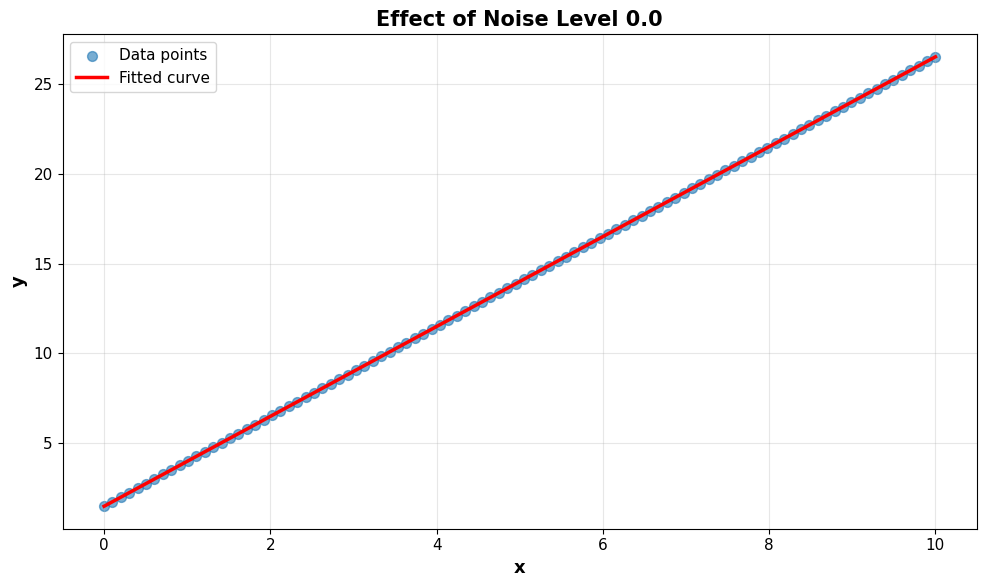

  [2/5] Plotting noise level: 0.05
  → Saved to plots/exp1_noise_0.05.png


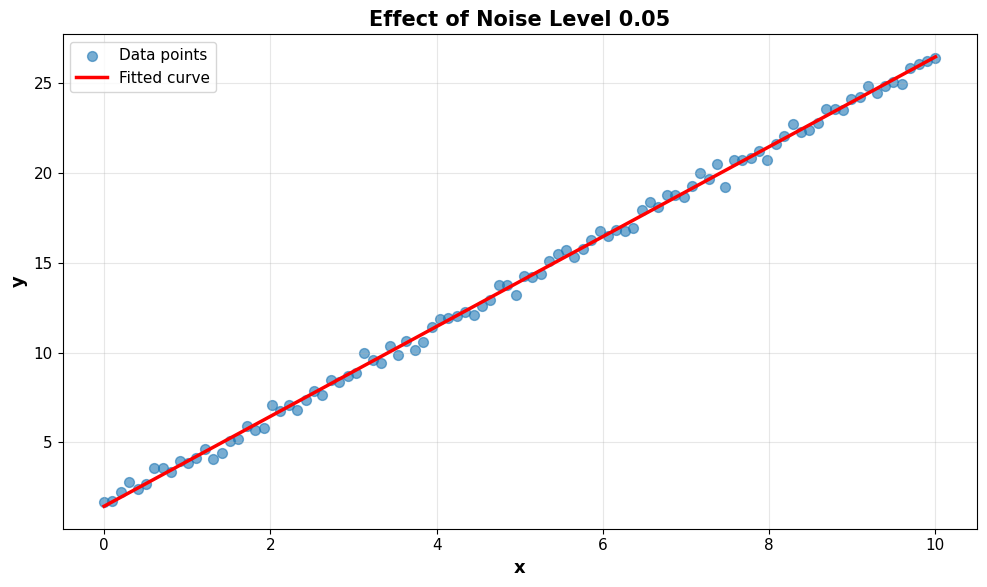

  [3/5] Plotting noise level: 0.10
  → Saved to plots/exp1_noise_0.1.png


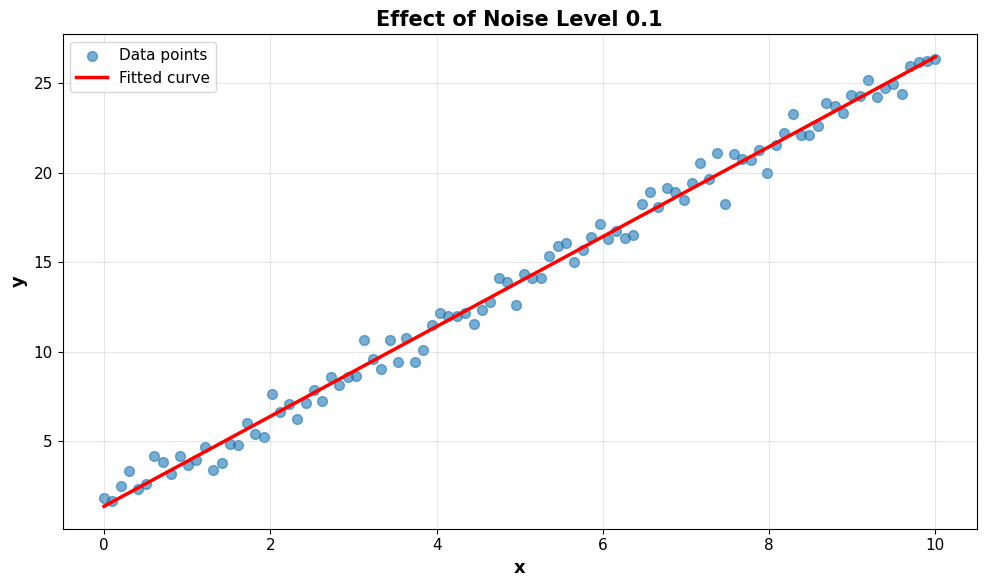

  [4/5] Plotting noise level: 0.20
  → Saved to plots/exp1_noise_0.2.png


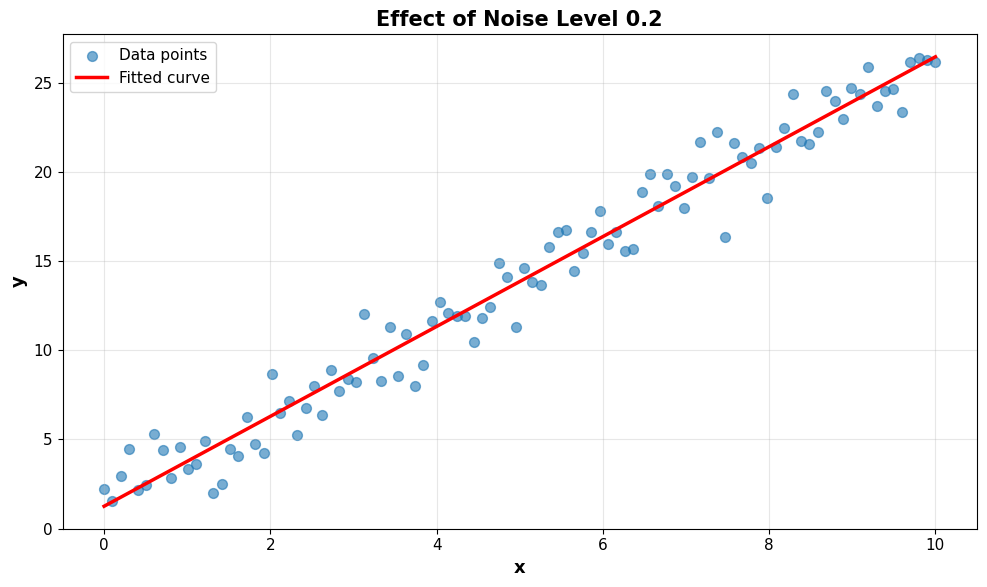

  [5/5] Plotting noise level: 0.50
  → Saved to plots/exp1_noise_0.5.png


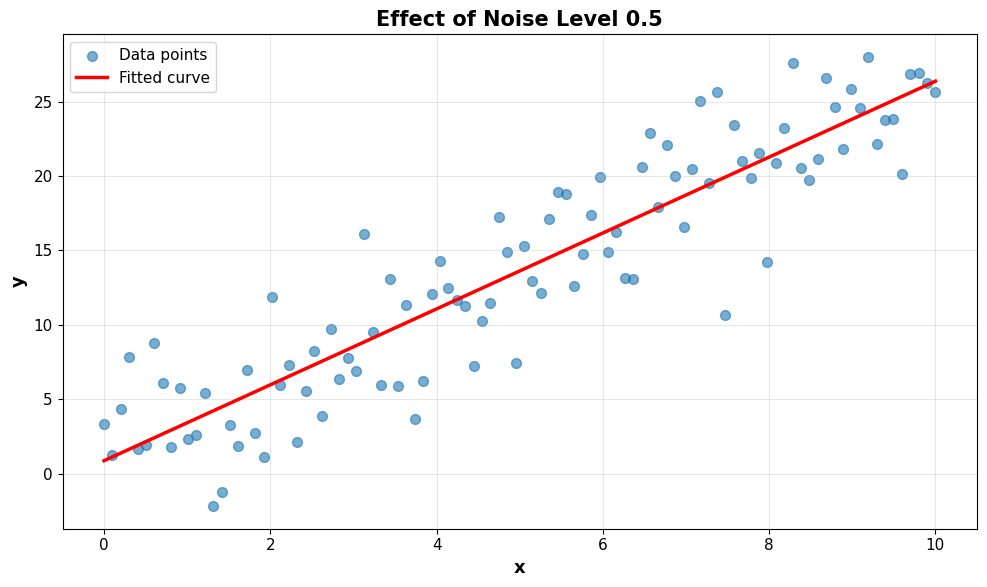


✓ Experiment 1 completed!



In [ ]:
# CELL 6: Experiment 1 - Effect of Noise Levels
# ============================================================================
print("="*70)
print("EXPERIMENT 1: Effect of Noise Levels on Linear Regression")
print("="*70)

noise_levels = [0.0, 0.05, 0.1, 0.2, 0.5]
results_noise = []
stored_data = []  # ← Store data for plotting

print("\nRunning experiments with different noise levels...")
for i, noise in enumerate(noise_levels, 1):
    print(f"  [{i}/{len(noise_levels)}] Testing noise level: {noise:.2f}")
    A, b, true_params = generate_linear_data(n_points=100, noise_level=noise)
    x_solution, metrics = solve_normal_equations(A, b)
    error_metrics = calculate_error_metrics(b, A @ x_solution)

    # Store data for later plotting
    stored_data.append((noise, A, b, x_solution))  # ← Save everything

    results_noise.append({
        'noise': noise,
        'true_m': true_params[0],
        'true_c': true_params[1],
        'est_m': x_solution[0],
        'est_c': x_solution[1],
        'rmse': error_metrics['RMSE'],
        'r2': error_metrics['R²'],
        'ssr': error_metrics['SSR']
    })

# Print results table
print("\n" + "="*80)
print(f"{'Noise':<8} {'True [m,c]':<18} {'Est [m,c]':<18} {'RMSE':<10} {'R²':<8} {'SSR':<10}")
print("="*80)
for row in results_noise:
    print(f"{row['noise']:<8.2f} [{row['true_m']:.2f}, {row['true_c']:.2f}]"
          f"{' '*7}[{row['est_m']:.2f}, {row['est_c']:.2f}]"
          f"{' '*6}{row['rmse']:<10.4f} {row['r2']:<8.4f} {row['ssr']:<10.2f}")
print("="*80)

# Visualizing all noise levels (using stored data)
print("\nGenerating visualizations for all noise levels...")
for i, (noise, A, b, x_solution) in enumerate(stored_data, 1):  # ← Use stored data
    print(f"  [{i}/{len(noise_levels)}] Plotting noise level: {noise:.2f}")
    plot_fitted_curve(A, b, x_solution, f"Effect of Noise Level {noise}", save_name=f"exp1_noise_{noise}")

print("\n✓ Experiment 1 completed!\n")

EXPERIMENT 2: Polynomial Fitting with Different Degrees

Testing polynomial degree: 1
--------------------------------------------------
  Solution: [ 0.98669655 -0.2758964 ]
  R² score: 0.9917
  RMSE: 0.0735
  Time: 1.587 ms
  Condition number: 1.38e+02

Testing polynomial degree: 2
--------------------------------------------------
  Solution: [ 0.08166635 -0.12157773  1.28416864]
  R² score: 0.9919
  RMSE: 3.4713
  Time: 0.222 ms
  Condition number: 2.08e+04

Testing polynomial degree: 3
--------------------------------------------------
  Solution: [  4.39774626 -40.06246005  13.09660324   2.19721928]
  R² score: 0.9925
  RMSE: 79.6726
  Time: 0.242 ms
  Condition number: 3.67e+06

Testing polynomial degree: 4
--------------------------------------------------
  Solution: [  9.87691672 -33.31773604  13.87881643   1.48055797  -0.40724059]
  R² score: 0.9926
  RMSE: 33.5658
  Time: 0.151 ms
  Condition number: 7.91e+08

Testing polynomial degree: 5
-----------------------------------

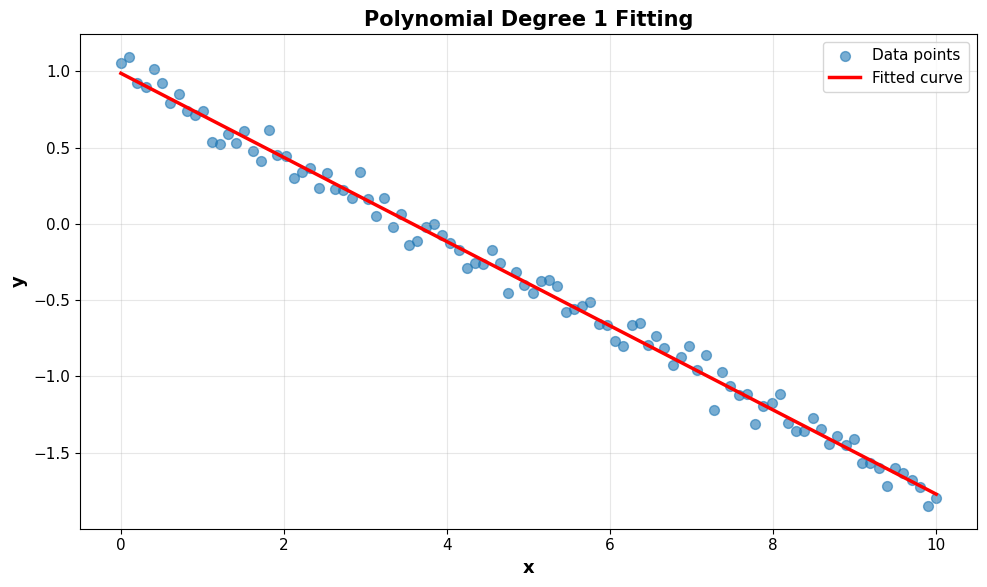

  [2/5] Plotting polynomial degree: 2
  → Saved to plots/exp2_degree_2.png


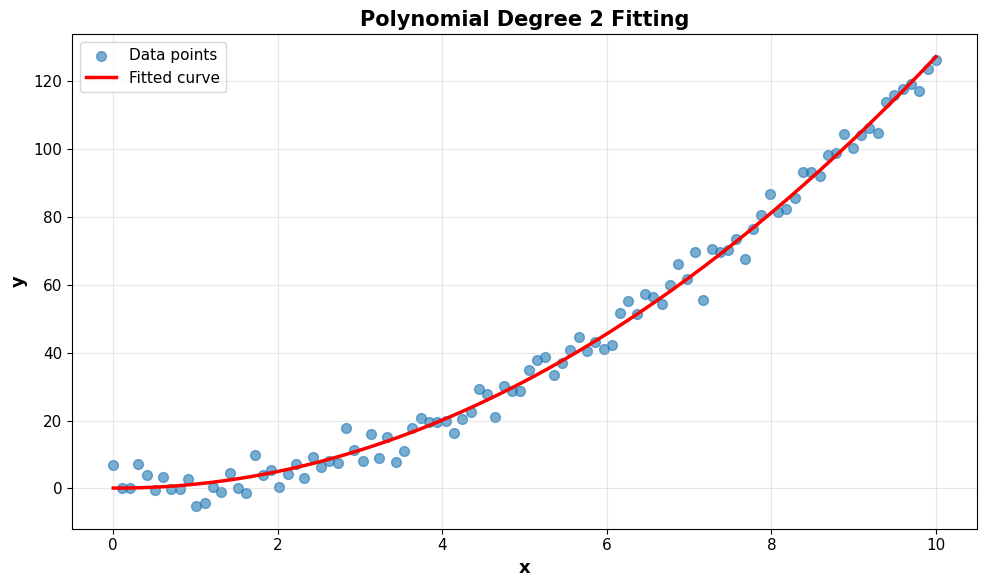

  [3/5] Plotting polynomial degree: 3
  → Saved to plots/exp2_degree_3.png


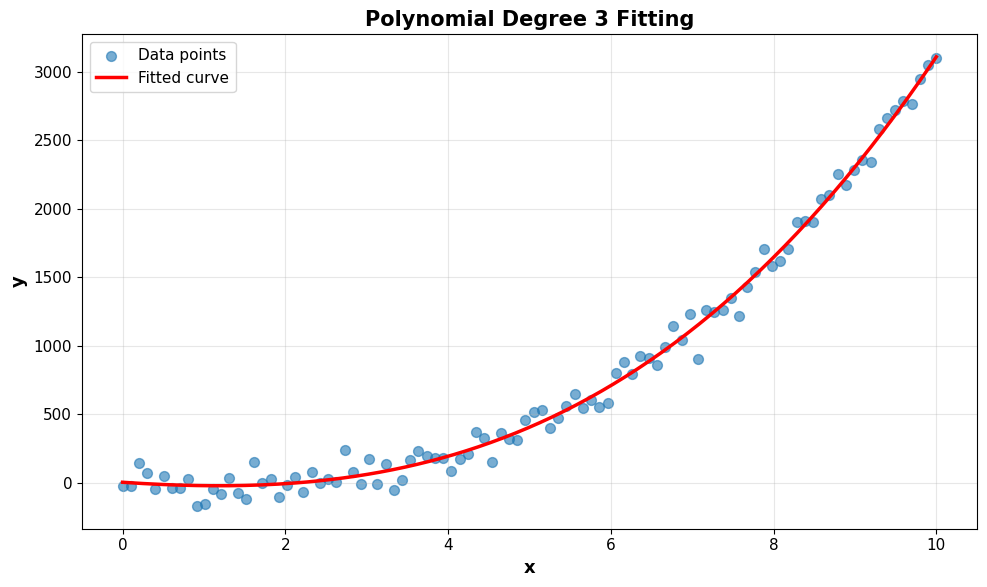

  [4/5] Plotting polynomial degree: 4
  → Saved to plots/exp2_degree_4.png


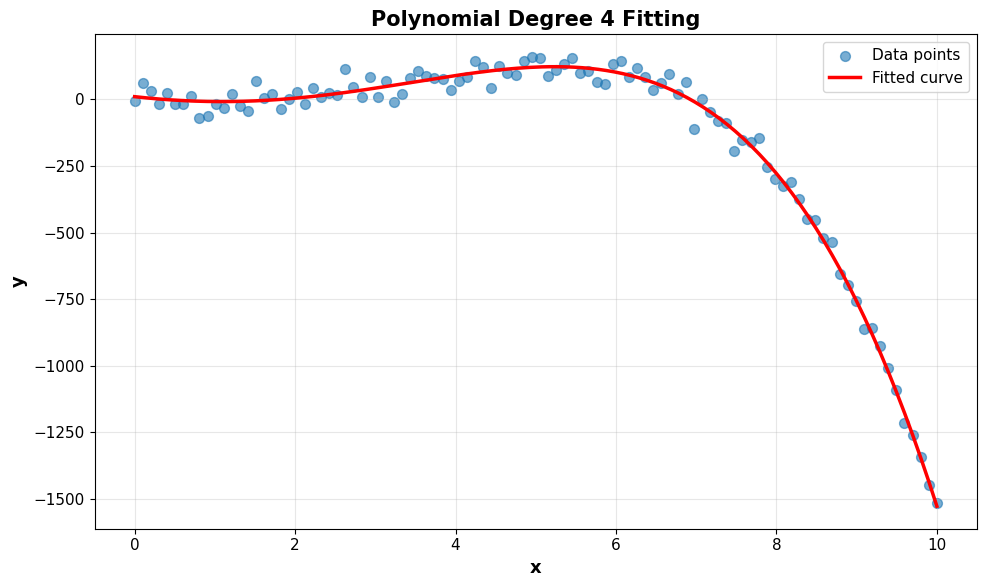

  [5/5] Plotting polynomial degree: 5
  → Saved to plots/exp2_degree_5.png


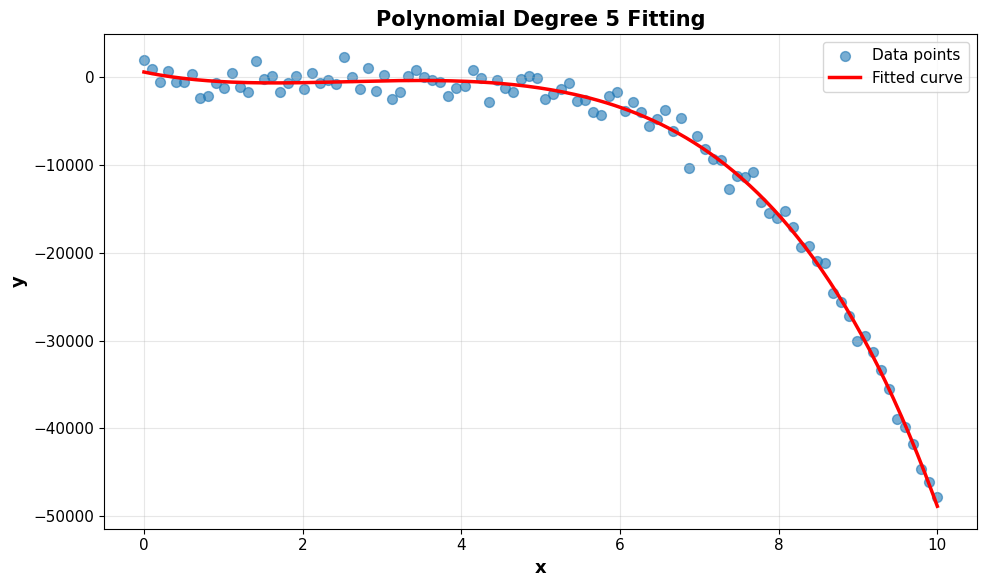

✓ Experiment 2 completed!



In [ ]:
# CELL 7: Experiment 2 - Polynomial Degrees
# ============================================================================
print("="*70)
print("EXPERIMENT 2: Polynomial Fitting with Different Degrees")
print("="*70)

degrees = [1, 2, 3, 4, 5]
results_poly = []

for degree in degrees:
    print(f"\nTesting polynomial degree: {degree}")
    print("-" * 50)
    A, b, true_params = generate_polynomial_data(n_points=100, degree=degree, noise_level=0.1)

    x_normal, metrics_normal = solve_normal_equations(A, b)
    error_metrics = calculate_error_metrics(b, A @ x_normal)

    print(f"  Solution: {x_normal}")
    print(f"  R² score: {error_metrics['R²']:.4f}")
    print(f"  RMSE: {error_metrics['RMSE']:.4f}")
    print(f"  Time: {metrics_normal['time_ms']:.3f} ms")
    print(f"  Condition number: {metrics_normal['condition_number']:.2e}")

    results_poly.append({
        'degree': degree,
        'r2': error_metrics['R²'],
        'rmse': error_metrics['RMSE'],
        'time': metrics_normal['time_ms'],
        'cond': metrics_normal['condition_number']
    })

# Summary table
print("\n" + "="*70)
print(f"{'Degree':<10} {'R²':<10} {'RMSE':<12} {'Time (ms)':<12} {'Cond. Num':<15}")
print("="*70)
for row in results_poly:
    print(f"{row['degree']:<10} {row['r2']:<10.4f} {row['rmse']:<12.4f} "
          f"{row['time']:<12.3f} {row['cond']:<15.2e}")
print("="*70)

# Visualize all polynomial degrees
print("\nGenerating visualizations for all polynomial degrees...")
for i, degree in enumerate(degrees, 1):
    print(f"  [{i}/{len(degrees)}] Plotting polynomial degree: {degree}")
    A, b, _ = generate_polynomial_data(n_points=100, degree=degree, noise_level=0.1)
    x_solution, _ = solve_normal_equations(A, b)
    plot_fitted_curve(A, b, x_solution, f"Polynomial Degree {degree} Fitting", save_name=f"exp2_degree_{degree}")

print("✓ Experiment 2 completed!\n")

EXPERIMENT 3: Detailed Method Comparison (Quadratic)

Method               Time (ms)    SSR          R²         Cond. Num      
Normal Equations     0.2410       1204.9781    0.9919     2.08e+04       
QR Decomposition     0.9618       1204.9781    0.9919     1.44e+02       
NumPy lstsq          0.1886       1204.9781    0.9919     1.44e+02       
  → Saved to plots/exp3_method_comparison.png


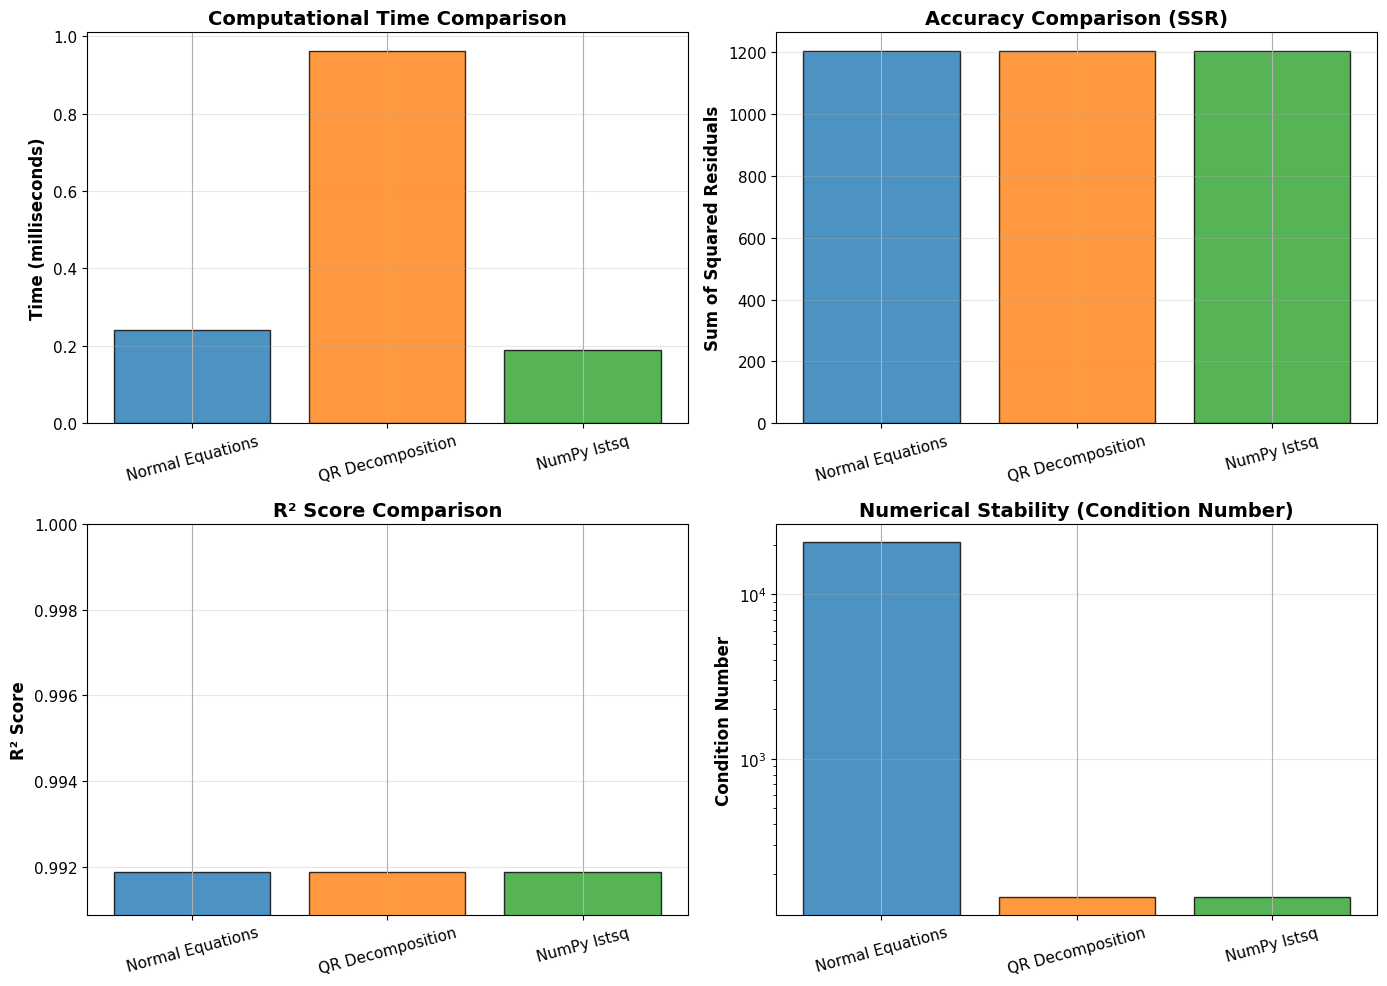

✓ Experiment 3 completed!



In [ ]:
# CELL 8: Experiment 3 - Method Comparison
# ============================================================================
print("="*70)
print("EXPERIMENT 3: Detailed Method Comparison (Quadratic)")
print("="*70)

A, b, _ = generate_polynomial_data(n_points=100, degree=2, noise_level=0.1)
results = compare_methods(A, b)

print("\n" + "="*85)
print(f"{'Method':<20} {'Time (ms)':<12} {'SSR':<12} {'R²':<10} {'Cond. Num':<15}")
print("="*85)

for method_name, result in results.items():
    time_ms = result['metrics']['time_ms']
    ssr = result['metrics']['ssr']
    r2 = result['error_metrics']['R²']
    cond = result['metrics']['condition_number']
    print(f"{method_name:<20} {time_ms:<12.4f} {ssr:<12.4f} {r2:<10.4f} {cond:<15.2e}")

print("="*85)

plot_method_comparison(results, save_name="exp3_method_comparison")

print("✓ Experiment 3 completed!\n")

In [ ]:
# CELL 9: Download Files
# ============================================================================

from google.colab import files
import shutil

# Create zip file
shutil.make_archive('least_squares_plots', 'zip', 'plots')

# Download
files.download('least_squares_plots.zip')

print("✓ Downloaded least_squares_plots.zip")
print("  Extract this file to get all your plots for the report!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Downloaded least_squares_plots.zip
  Extract this file to get all your plots for the report!
